# Imports & Data Organization

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter

import neuscitk as ntk

In [2]:
#get dataset
dataset = ntk.LabChartDataset('/Users/prestonsands/Desktop/NEUSCI 302/Lab1/BWPSPA_Lab1MAT.mat')

In [3]:
#organize blocks into pages
page_map = {
    'spontaneousTrials' : list(range(0,10)),
    'spine3trials' : list(range(10,15)),
    'spine4trials' : list(range(15,20)),
    'spine2trials' : list(range(20,25)),
    'spine1trials' : list(range(25,30)),
    'freqTrials' : list(range(30,35))
}

dataset.organize_by_pages(page_map)

#define new datasets
spontaneousTrials = dataset.get_page('spontaneousTrials')
spine1trials= dataset.get_page('spine1trials')
spine2trials= dataset.get_page('spine2trials')
spine3trials= dataset.get_page('spine3trials')
spine4trials= dataset.get_page('spine4trials')
freqTrials= dataset.get_page('freqTrials')

#concatonated groups
spontaneousConcat = dataset.concat_blocks(range(0,10))
spine3concat = dataset.concat_blocks(range(10,15))
spine4concat = dataset.concat_blocks(range(15,20))
spine2concat = dataset.concat_blocks(range(20,25))
spine1concat = dataset.concat_blocks(range(25,30))
freqConcat = dataset.concat_blocks(range(30,35))

allData = dataset.concat_blocks(range(0,35))

In [4]:
#clean data
start_index = 3061588 - 100
end_index = 3061588 + 100

spine1concat[0][start_index:end_index] = 0

# Define Libraries & Functions

In [5]:
#colors
colors = {
    'red': '#FF4F4F',
    'red1': '#FFBBBB',
    'red2': '#FF9B9B',
    'red3': '#FF8383',
    'red4': '#FF6969',
    'red5': '#FF4F4F',
    'red6': '#C73737',
    'red7': '#871C1C',
    'red8': '#4B0202',
    
    'gold': '#FFAE21',
    'gold1': '#FDE8C1',
    'gold2': '#FEDF94',
    'gold3': '#FED96C',
    'gold4': '#FFC044',
    'gold5': '#FFAE21',
    'gold6': '#D27D18',
    'gold7': '#A15B0E',
    'gold8': '#693703',

    'aqua': '#01CFCC',
    'aqua1': '#BFF8D0',
    'aqua2': '#96EFCF',
    'aqua3': '#6DE6CE',
    'aqua4': '#3ADBD8',
    'aqua5': '#01B0CF',
    'aqua6': '#0299AD',
    'aqua7': '#04768C',
    'aqua8': '#07435C',

    'blue': '#6480FF',
    'blue1': '#D0F2FF',
    'blue2': '#B2DBFF',
    'blue3': '#96BCFF',
    'blue4': '#7EA4FF',
    'blue5': '#647DFF',
    'blue6': '#535AD1',
    'blue7': '#3A29B8',
    'blue8': '#3F0F8D',

    'green1': '#94DD8B',
    'green2': '#0BB68C',
    'green3': '#038174',
}

In [6]:
def custom_formatter(x, _):
    return f"{x:.1f}" if x % 1 else f"{int(x)}"

In [7]:
def plot_waveforms(data, num_clusters: int, time: int):
    """
    Plots a PCA scatter plot and waveforms for a given dataset.
    
    Parameters:
    - data: A dataset object with `pca_embeddings`, `labels`, and `get_cluster_waveforms` method.
    - num_clusters: Number of clusters to plot waveforms for.
    """
    n_cols = 3  
    # Calculate the number of rows needed
    n_rows = (num_clusters + 1 + n_cols - 1) // n_cols

    # Create the figure and gridspec layout
    fig = plt.figure(figsize=(18, n_rows * 5))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=0.3)

    # PCA Scatter Plot Data
    PC1 = data.pca_embeddings[:, 0]
    PC2 = data.pca_embeddings[:, 1]

    # Get unique cluster labels and assign default colors (C0, C1, ...)
    unique_labels = np.unique(data.labels)
    colors = [f'C{i}' for i in range(len(unique_labels))]

    # Create a mapping from cluster label to color
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Apply the color mapping to the data points
    point_colors = [label_to_color[label] for label in data.labels]

    # Plot the PCA scatter plot in the first grid position (top-left)
    ax_pca = fig.add_subplot(gs[0])
    scatter = ax_pca.scatter(PC1, PC2, c=point_colors, edgecolor='black', linewidth=0.25)
    ax_pca.set_title('PCA Space')
    ax_pca.set_xlabel('PC1')
    ax_pca.set_ylabel('PC2')

    # Loop through the clusters and plot the waveforms in the remaining grid slots
    for i in range(num_clusters):
        # Get the waveforms for the current cluster
        temp = data.get_cluster_waveforms(i)
        
        # Average across the first axis (axis=0)
        temp_avg = np.mean(temp, axis=0)
        
        # Convert averaged waveform from V to mV by multiplying by 1000
        temp_mV = temp_avg * 1000
        n = temp.shape[0]
        EstimatedFR = n / time  # Replace 80 with your actual recording duration if needed
        
        # Create subplot at the appropriate position in the grid, starting from the second grid position
        ax = fig.add_subplot(gs[i + 1])  # Start from index 1 (second position)
        
        # Plot the averaged waveform using the default palette colors (C0, C1, etc.)
        ax.plot(temp_mV, color=f'C{i}')
        
        # Set title and labels
        ax.set_title(f'Cluster {i} Waveform, FR={EstimatedFR:.2f} Hz')
        ax.set_ylabel('Amplitude (mV)')  # Label the y-axis in mV
        ax.set_xlabel('Time (samples)')  # Adjust as needed for your x-axis

    # Show the full grid of plots
    plt.show()

In [8]:
#split array by stimulus
def splitByStim(data, sample_rate=40000, start_sec=2, duration_sec=2, interval_samples=1360000, num_arrays=8):
    arrays = []
    duration_samples = sample_rate * duration_sec

    for i in range(num_arrays):
        offset_sec = start_sec + i * 2
        offset_samples = offset_sec * sample_rate

        array_i = []  
        for start_idx in range(offset_samples, data.shape[1], interval_samples):
            end_idx = start_idx + duration_samples

            if end_idx <= data.shape[1]:
                array_i.append(data[:, start_idx:end_idx])
            else:
                print(f"  Skipped chunk: end_idx ({end_idx}) exceeds data length ({data.shape[1]})")

        if array_i:
            arrays.append(np.concatenate(array_i, axis=1))
        else:
            print(f"No data found for array {i}, skipping concatenation.")

    return arrays

In [9]:
def split_by_recordings(sorted_spikes: ntk.SortedSpikes, cluster: int, recording_intervals: np.ndarray) -> dict:

    spike_times = sorted_spikes.get_cluster_spike_times(cluster)
    wave_forms = sorted_spikes.get_cluster_waveforms(cluster)

    split = {f'recording_{i}' : {} for i in range(len(recording_intervals))}

    for i in range(1, len(recording_intervals)):
        indices = np.where(
            (spike_times >= recording_intervals[i - 1]) &
            (spike_times < recording_intervals[i])
        )

        recording_waveforms = wave_forms[indices]
        recording_spike_times = spike_times[indices] - recording_intervals[i - 1]

        split[f'recording_{i - 1}']['waveforms'] = recording_waveforms
        split[f'recording_{i - 1}']['spike_times'] = recording_spike_times
    
    return split

# Whole Recording Data Processing
## Spike Sorting

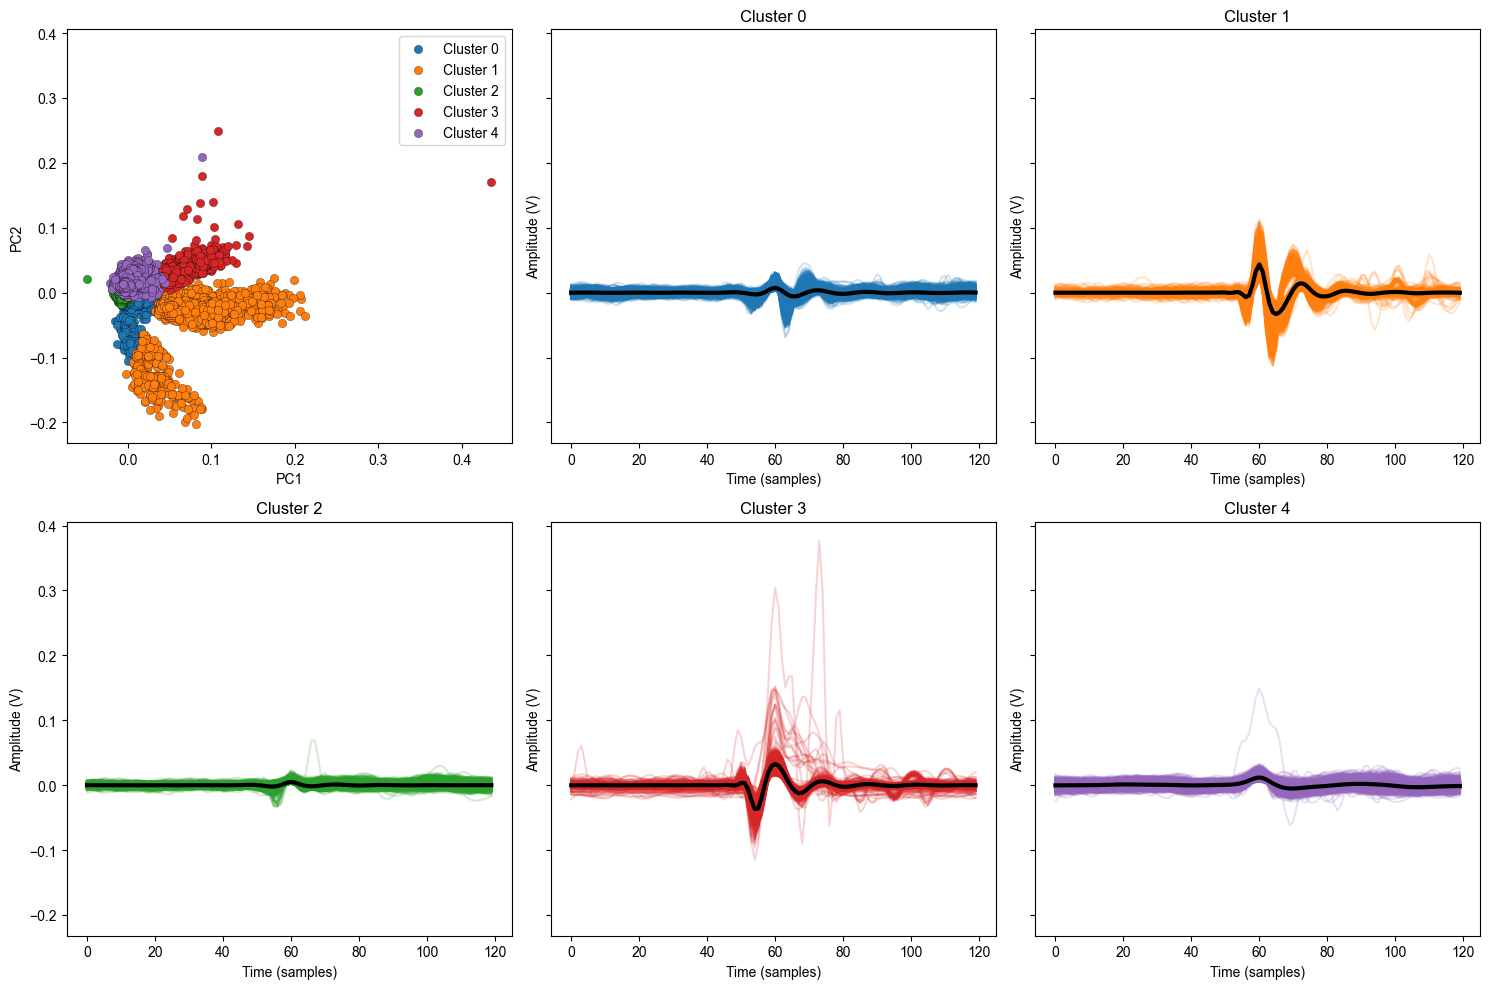

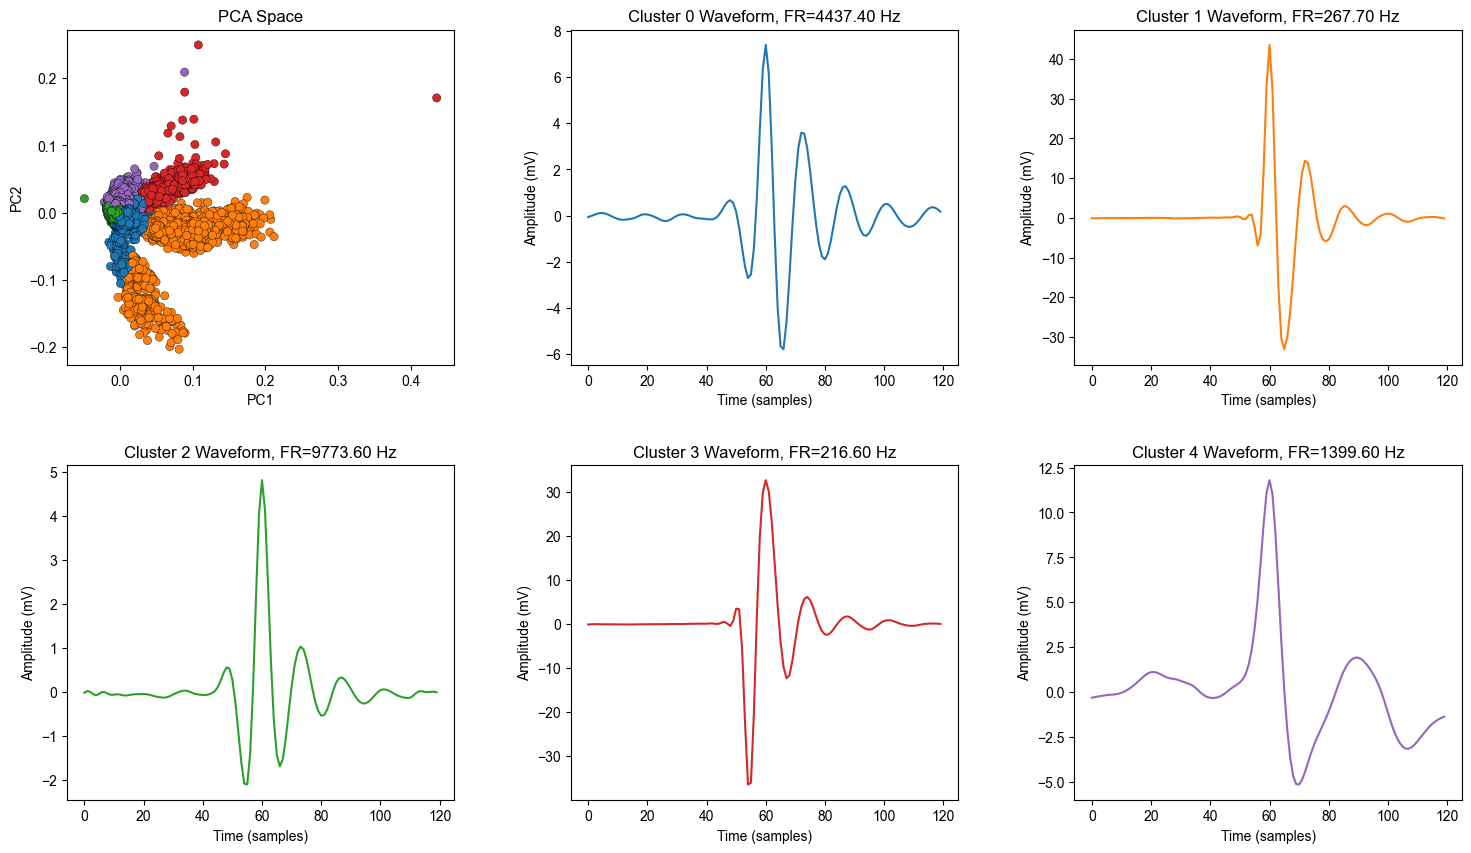

In [74]:
#sort all spikes
num_clusters = 5

sorted_spikes = ntk.sort_spikes(allData[0], fs=dataset.fs, threshold_multiplier=3, waveform_window = 40 * 3, n_clusters=num_clusters)
sorted_spikes.plot_clusters()
plot_waveforms(sorted_spikes, num_clusters, 10)

## Processing

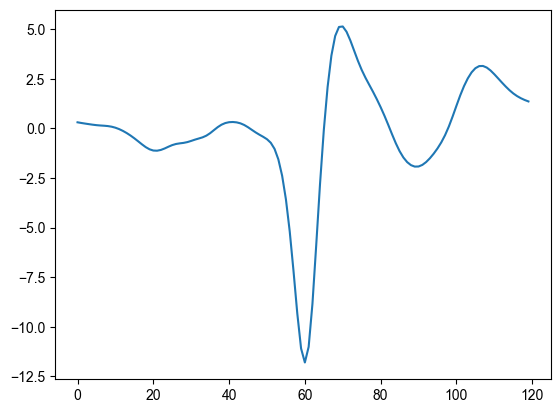

In [75]:
wholedata_spike_times = sorted_spikes.get_cluster_spike_times(4)
wholedata_cluster = sorted_spikes.get_cluster_waveforms(4)
wholedata_cluster_avg = np.mean(wholedata_cluster, axis=0)
plt.plot(wholedata_cluster_avg *-1000)

In [76]:
#split by recording
split = split_by_recordings(sorted_spikes, 4, np.arange(0, 34*40000*35, 34*40000))

In [80]:
# Create lists to store results
wfs_byRecording = []
avg_waveforms = []
firing_rates = []
spike_nums = []
spike_times = []

# Loop through 35 recordings
for i in range(35):
    # Check if the recording exists and has the necessary keys
    recording_key = f'recording_{i}'
    if recording_key in split and 'waveforms' in split[recording_key] and 'spike_times' in split[recording_key]:
        # Access waveform and spike time data for the recording
        rec_wfs = split[recording_key]['waveforms']
        rec_times = split[recording_key]['spike_times']
        
        # Calculate spike number and firing rate
        rec_spike_num = rec_times.shape[0]
        rec_FR = rec_spike_num / 16
        
        # Compute the average waveform
        avg_wfs = np.mean(rec_wfs, axis=0)

        # Store the results in the lists
        wfs_byRecording.append(rec_wfs)
        spike_nums.append(rec_spike_num)
        spike_times.append(rec_times)
        avg_waveforms.append(avg_wfs)
        firing_rates.append(rec_FR)
    else:
        print(f"Missing data for {recording_key}")

Missing data for recording_34


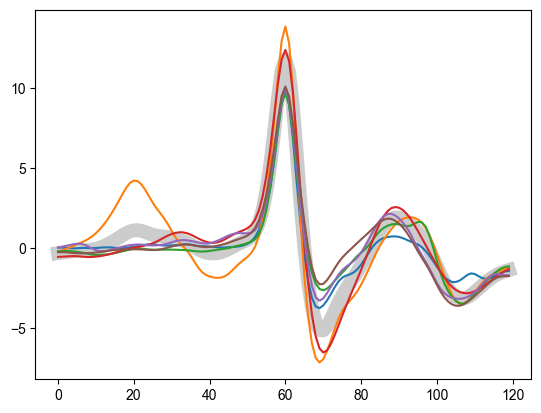

In [41]:
#sponateous
spontaneous_wfs = []
for i in range(10):
    spontaneous_wfs.append(split[f'recording_{i}']['waveforms'])

spontaneous_wfs = np.vstack(spontaneous_wfs)
avg_spontaneous_wf = np.mean(spontaneous_wfs, axis=0)

#spine 1
spine1_wfs = []
for i in range(10,15):
    spine1_wfs.append(split[f'recording_{i}']['waveforms'])

spine1_wfs = np.vstack(spine1_wfs)
avg_spine1_wf = np.mean(spine1_wfs, axis=0)

#spine 2
spine2_wfs = []
for i in range(15,20):
    spine2_wfs.append(split[f'recording_{i}']['waveforms'])

spine2_wfs = np.vstack(spine2_wfs)
avg_spine2_wf = np.mean(spine2_wfs, axis=0)

#spine 3
spine3_wfs = []
for i in range(20,25):
    spine3_wfs.append(split[f'recording_{i}']['waveforms'])

spine3_wfs = np.vstack(spine3_wfs)
avg_spine3_wf = np.mean(spine3_wfs, axis=0)

#spine 4
spine4_wfs = []
for i in range(25,30):
    spine4_wfs.append(split[f'recording_{i}']['waveforms'])

spine4_wfs = np.vstack(spine4_wfs)
avg_spine4_wf = np.mean(spine4_wfs, axis=0)

#frequency data spine 1
spine1freq_wfs = []
for i in range(30,34):
    spine1freq_wfs.append(split[f'recording_{i}']['waveforms'])

spine1freq_wfs = np.vstack(spine1freq_wfs)
avg_spine1freq_wf = np.mean(spine1freq_wfs, axis=0)

plt.plot(wholedata_cluster_avg *1000, alpha=.2, linewidth = 10, c='black')
plt.plot(avg_spontaneous_wf * 1000, c='C0')
plt.plot(avg_spine1_wf * 1000, c='C1')
plt.plot(avg_spine2_wf * 1000, c='C2')
plt.plot(avg_spine3_wf * 1000, c='C3')
plt.plot(avg_spine4_wf * 1000, c='C4')
plt.plot(avg_spine1freq_wf * 1000, c='C5')

In [42]:
# Sample rate and time segment details
sampling_rate = 40000  # 40k samples per second
time_segments = {
    'Amp1_spike_times': (2, 4),
    'Amp2_spike_times': (6, 8),
    'Amp3_spike_times': (10, 12),
    'Amp4_spike_times': (14, 16),
    'Amp5_spike_times': (18, 20),
    'Amp6_spike_times': (22, 24),
    'Amp7_spike_times': (26, 28),
    'Amp8_spike_times': (30, 32)
}

# Dictionary to store the results
spike_times_by_amp = {key: [] for key in time_segments}

# Loop through each recording in spike_times
for rec_idx, rec_spike_times in enumerate(spike_times):
    for amp_key, (start_sec, end_sec) in time_segments.items():
        # Convert time range to sample indices
        start_sample = start_sec * sampling_rate
        end_sample = end_sec * sampling_rate
        
        # Filter spike times that fall within the sample range
        filtered_spikes = rec_spike_times[(rec_spike_times >= start_sample) & (rec_spike_times < end_sample)]
        
        # Store the filtered spikes for this recording
        spike_times_by_amp[amp_key].append(filtered_spikes)

# Now spike_times_by_amp contains the spike times for each amplitude across all recordings.

# Figure 1D

/var/folders/8m/rn7r2gs515b4cjxyfyfv6wz00000gn/T/ipykernel_19640/311543765.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


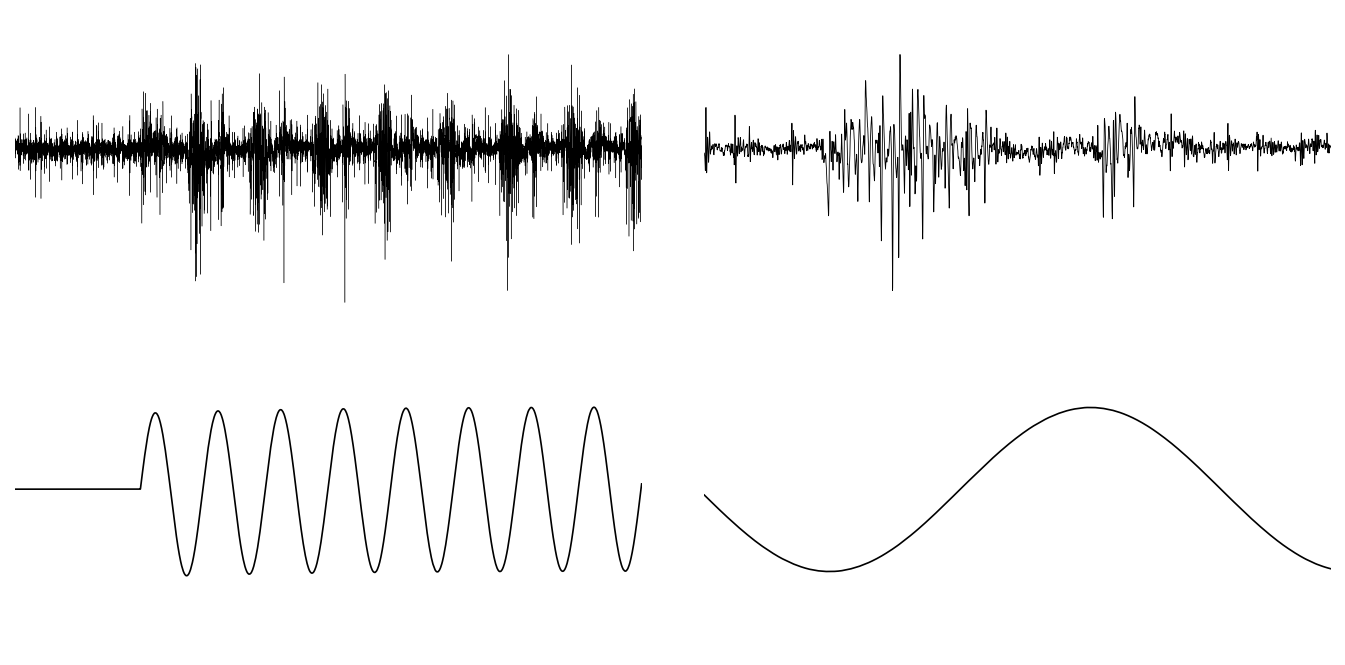

In [43]:
#figure 1D
fig = plt.figure(figsize=(11.32, 5.5), dpi=150)
gs1d = gridspec.GridSpec(2, 2, hspace=-0.02, wspace=0.1)

time1 = 1032000
time2 = 1072000

time3 = 1062000
time4 = 1066800

#plot1
ax1 = fig.add_subplot(gs1d[0, 0])
plt.plot(spine2trials['block_22'][0,time1:time2]*-1,
        color = 'black',
        linewidth = 0.2
        )
ax1.set_xticks([0, 4000, 40000])
ax1.set_yticks([-0.035, 0, 0.01, 0.025])

ax1.set_xbound([0, 40000])
ax1.set_ybound([-0.035, 0.025])

#plot2
ax2 = fig.add_subplot(gs1d[0, 1])
plt.plot(spine2trials['block_22'][0,time3:time4] *-1,
        color = 'black',
        linewidth = 0.4
        )
ax2.set_xticks([0, 400, 4800])
ax2.set_yticks([-0.035, 0, 0.01, 0.025])

ax2.set_xbound([0, 4800])
ax2.set_ybound([-0.035, 0.025])

#plot3
ax3 = fig.add_subplot(gs1d[1, 0])
plt.plot(spine2trials['block_22'][1,time1:time2],
        color = 'black',
        linewidth = 0.8
        )
ax3.set_xticks([0, 4000, 40000])
ax3.set_yticks([-0.2, 0, 0.1, 0.2])

ax3.set_xbound([0, 40000])
ax3.set_ybound([-0.4, 0.4])

#plot4
ax4 = fig.add_subplot(gs1d[1, 1])
plt.plot(spine2trials['block_22'][1,time3:time4],
        color = 'black',
        linewidth = 0.8
        )
ax4.set_xticks([0, 400, 4800])
ax4.set_yticks([-0.2, 0, 0.1, 0.2])

ax4.set_xbound([0, 4800])
ax4.set_ybound([-0.4, 0.4])

#clean
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.tight_layout()
plt.show()

# Processing For Figure 2

In [290]:
all_wfs = sorted_spikes.get_cluster_waveforms(4)
all_wfs_std = np.std(all_wfs, axis=0)

In [291]:
# Create a new array FR_reorder based on the original firing_rates array
FR_reorder = np.copy(firing_rates)

# Apply the rearrangement
FR_reorder[0:10] = firing_rates[0:10]    # Row 0-9: Spontaneous data (unchanged)
FR_reorder[10:15] = firing_rates[25:30]  # Row 10-14: Spine 1 amplitude data (was 25-29)
FR_reorder[15:20] = firing_rates[20:25]  # Row 15-19: Spine 2 amplitude data (was 20-24)
FR_reorder[20:25] = firing_rates[10:15]  # Row 20-24: Spine 3 amplitude data (was 10-14)
FR_reorder[25:30] = firing_rates[15:20]  # Row 25-29: Spine 4 amplitude data (was 15-19)
FR_reorder[30:34] = firing_rates[30:34]  # Row 30-33: Spine 1 frequency data (unchanged)

In [292]:
stim_start_times = [80000, 240000, 400000, 560000, 720000, 880000, 1040000, 1200000]
stim_end_times = [160000, 320000, 480000, 640000, 800000, 960000, 1120000, 1280000]

## Average Waveforms & FR By Amp

In [293]:
firing_rate_dict = {}

In [294]:
#get avg waveforms for spine 1
S1A1_avg_wf =  []
S1A2_avg_wf =  []
S1A3_avg_wf =  []
S1A4_avg_wf =  []
S1A5_avg_wf =  []
S1A6_avg_wf =  []
S1A7_avg_wf =  []
S1A8_avg_wf =  []

S1A1_FR =  []
S1A2_FR =  []
S1A3_FR =  []
S1A4_FR =  []
S1A5_FR =  []
S1A6_FR =  []
S1A7_FR =  []
S1A8_FR =  []

# Loop over stimulus amplitudes A = 1 to 8
for A in range(8):
    # Get start and end time for the current amplitude A
    stim_start = stim_start_times[A]
    stim_end = stim_end_times[A]
    
    # Initialize list to store waveforms for all recordings for the current amplitude
    wfs_per_stim = []
    
    # Loop over recordings R = 1 to 5 (index 25 to 29)
    for R in range(25, 30):
        # Get indices of spikes that fall within the current stimulus time window
        stim_indices = (spike_times[R] > stim_start) & (spike_times[R] < stim_end)
        
        # Get the waveforms corresponding to the selected spikes
        wfs = wfs_byRecording[R][stim_indices]
        
        # Append waveforms to the list for this amplitude
        wfs_per_stim.append(wfs)
    
    # Concatenate waveforms from all recordings for this amplitude
    combined_wfs = np.vstack(wfs_per_stim)
    
    # Calculate the average waveform for the current amplitude
    avg_wf = np.mean(combined_wfs, axis=0)
    
    # Dynamically create global variables for each stimulus amplitude (e.g., S1A1_avg_wf)
    globals()[f'S1A{A+1}_avg_wf'] = avg_wf*-1000

    FR = len(combined_wfs) / 10
    globals()[f'S1A{A+1}_FR'] = FR
    firing_rate_dict[f'S1A{A+1}_FR'] = FR

In [295]:
#get avg waveforms for spine 2
S2A1_avg_wf =  []
S2A2_avg_wf =  []
S2A3_avg_wf =  []
S2A4_avg_wf =  []
S2A5_avg_wf =  []
S2A6_avg_wf =  []
S2A7_avg_wf =  []
S2A8_avg_wf =  []

S2A1_FR =  []
S2A2_FR =  []
S2A3_FR =  []
S2A4_FR =  []
S2A5_FR =  []
S2A6_FR =  []
S2A7_FR =  []
S2A8_FR =  []

# Loop over stimulus amplitudes A = 1 to 8
for A in range(8):
    # Get start and end time for the current amplitude A
    stim_start = stim_start_times[A]
    stim_end = stim_end_times[A]
    
    # Initialize list to store waveforms for all recordings for the current amplitude
    wfs_per_stim = []
    
    # Loop over recordings R = 1 to 5 (index 25 to 29)
    for R in range(20, 25):
        # Get indices of spikes that fall within the current stimulus time window
        stim_indices = (spike_times[R] > stim_start) & (spike_times[R] < stim_end)
        
        # Get the waveforms corresponding to the selected spikes
        wfs = wfs_byRecording[R][stim_indices]
        
        # Append waveforms to the list for this amplitude
        wfs_per_stim.append(wfs)
    
    # Concatenate waveforms from all recordings for this amplitude
    combined_wfs = np.vstack(wfs_per_stim)
    
    # Calculate the average waveform for the current amplitude
    avg_wf = np.mean(combined_wfs, axis=0)
    
    # Dynamically create global variables for each stimulus amplitude (e.g., S1A1_avg_wf)
    globals()[f'S2A{A+1}_avg_wf'] = avg_wf*-1000

    FR = len(combined_wfs) / 10
    globals()[f'S2A{A+1}_FR'] = FR
    firing_rate_dict[f'S2A{A+1}_FR'] = FR

In [296]:
#get avg waveforms for spine 3
S3A1_avg_wf =  []
S3A2_avg_wf =  []
S3A3_avg_wf =  []
S3A4_avg_wf =  []
S3A5_avg_wf =  []
S3A6_avg_wf =  []
S3A7_avg_wf =  []
S3A8_avg_wf =  []

S3A1_FR =  []
S3A2_FR =  []
S3A3_FR =  []
S3A4_FR =  []
S3A5_FR =  []
S3A6_FR =  []
S3A7_FR =  []
S3A8_FR =  []

# Loop over stimulus amplitudes A = 1 to 8
for A in range(8):
    # Get start and end time for the current amplitude A
    stim_start = stim_start_times[A]
    stim_end = stim_end_times[A]
    
    # Initialize list to store waveforms for all recordings for the current amplitude
    wfs_per_stim = []
    
    # Loop over recordings R = 1 to 5 (index 25 to 29)
    for R in range(10, 15):
        # Get indices of spikes that fall within the current stimulus time window
        stim_indices = (spike_times[R] > stim_start) & (spike_times[R] < stim_end)
        
        # Get the waveforms corresponding to the selected spikes
        wfs = wfs_byRecording[R][stim_indices]
        
        # Append waveforms to the list for this amplitude
        wfs_per_stim.append(wfs)
    
    # Concatenate waveforms from all recordings for this amplitude
    combined_wfs = np.vstack(wfs_per_stim)
    
    # Calculate the average waveform for the current amplitude
    avg_wf = np.mean(combined_wfs, axis=0)
    
    # Dynamically create global variables for each stimulus amplitude (e.g., S1A1_avg_wf)
    globals()[f'S3A{A+1}_avg_wf'] = avg_wf*-1000

    FR = len(combined_wfs) / 10
    globals()[f'S3A{A+1}_FR'] = FR
    firing_rate_dict[f'S3A{A+1}_FR'] = FR

In [297]:
#get avg waveforms for spine 4
S4A1_avg_wf =  []
S4A2_avg_wf =  []
S4A3_avg_wf =  []
S4A4_avg_wf =  []
S4A5_avg_wf =  []
S4A6_avg_wf =  []
S4A7_avg_wf =  []
S4A8_avg_wf =  []

S4A1_FR =  []
S4A2_FR =  []
S4A3_FR =  []
S4A4_FR =  []
S4A5_FR =  []
S4A6_FR =  []
S4A7_FR =  []
S4A8_FR =  []

# Loop over stimulus amplitudes A = 1 to 8
for A in range(8):
    # Get start and end time for the current amplitude A
    stim_start = stim_start_times[A]
    stim_end = stim_end_times[A]
    
    # Initialize list to store waveforms for all recordings for the current amplitude
    wfs_per_stim = []
    
    # Loop over recordings R = 1 to 5 (index 25 to 29)
    for R in range(15, 20):
        # Get indices of spikes that fall within the current stimulus time window
        stim_indices = (spike_times[R] > stim_start) & (spike_times[R] < stim_end)
        
        # Get the waveforms corresponding to the selected spikes
        wfs = wfs_byRecording[R][stim_indices]
        
        # Append waveforms to the list for this amplitude
        wfs_per_stim.append(wfs)
    
    # Concatenate waveforms from all recordings for this amplitude
    combined_wfs = np.vstack(wfs_per_stim)
    
    # Calculate the average waveform for the current amplitude
    avg_wf = np.mean(combined_wfs, axis=0)
    
    # Dynamically create global variables for each stimulus amplitude (e.g., S1A1_avg_wf)
    globals()[f'S4A{A+1}_avg_wf'] = avg_wf*-1000

    FR = len(combined_wfs) / 10
    globals()[f'S4A{A+1}_FR'] = FR
    firing_rate_dict[f'S4A{A+1}_FR'] = FR

In [298]:
#get avg waveforms for the FR trials (spine 1)
S1F1_avg_wf =  []
S1F2_avg_wf =  []
S1F3_avg_wf =  []
S1F4_avg_wf =  []
S1F5_avg_wf =  []
S1F6_avg_wf =  []
S1F7_avg_wf =  []
S1F8_avg_wf =  []

S1F1_FR =  []
S1F2_FR =  []
S1F3_FR =  []
S1F4_FR =  []
S1F5_FR =  []
S1F6_FR =  []
S1F7_FR =  []
S1F8_FR =  []

# Loop over stimulus amplitudes F = 1 to 8
for F in range(8):
    # Get start and end time for the current freq F
    stim_start = stim_start_times[F]
    stim_end = stim_end_times[F]
    
    # Initialize list to store waveforms for all recordings for the current freq
    wfs_per_stim = []
    
    # Loop over recordings R = 1 to 4 (index 30 to 33)
    for R in range(30, 34):
        # Get indices of spikes that fall within the current stimulus time window
        stim_indices = (spike_times[R] > stim_start) & (spike_times[R] < stim_end)
        
        # Get the waveforms corresponding to the selected spikes
        wfs = wfs_byRecording[R][stim_indices]
        
        # Append waveforms to the list for this freq
        wfs_per_stim.append(wfs)
    
    # Concatenate waveforms from all recordings for this freq
    combined_wfs = np.vstack(wfs_per_stim)
    
    # Calculate the average waveform for the current freq
    avg_wf = np.mean(combined_wfs, axis=0)
    
    # Dynamically create global variables for each stimulus freq (e.g., S1F1_avg_wf)
    globals()[f'S1F{F+1}_avg_wf'] = avg_wf*-1000

    FR = len(combined_wfs) / 8
    globals()[f'S1F{F+1}_FR'] = FR
    firing_rate_dict[f'S1F{F+1}_FR'] = FR

## Spike Triggered Avg

In [299]:
sta_range = 2000
sta = [allData[1, spike_time - sta_range : spike_time + sta_range] for spike_time in wholedata_spike_times]
sta = np.vstack(sta)
sta_avg = np.mean(sta, axis=0)
sta_std = np.std(sta, axis=0)

# Figure 2
## Figure 2A-C

/var/folders/8m/rn7r2gs515b4cjxyfyfv6wz00000gn/T/ipykernel_19640/518883785.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


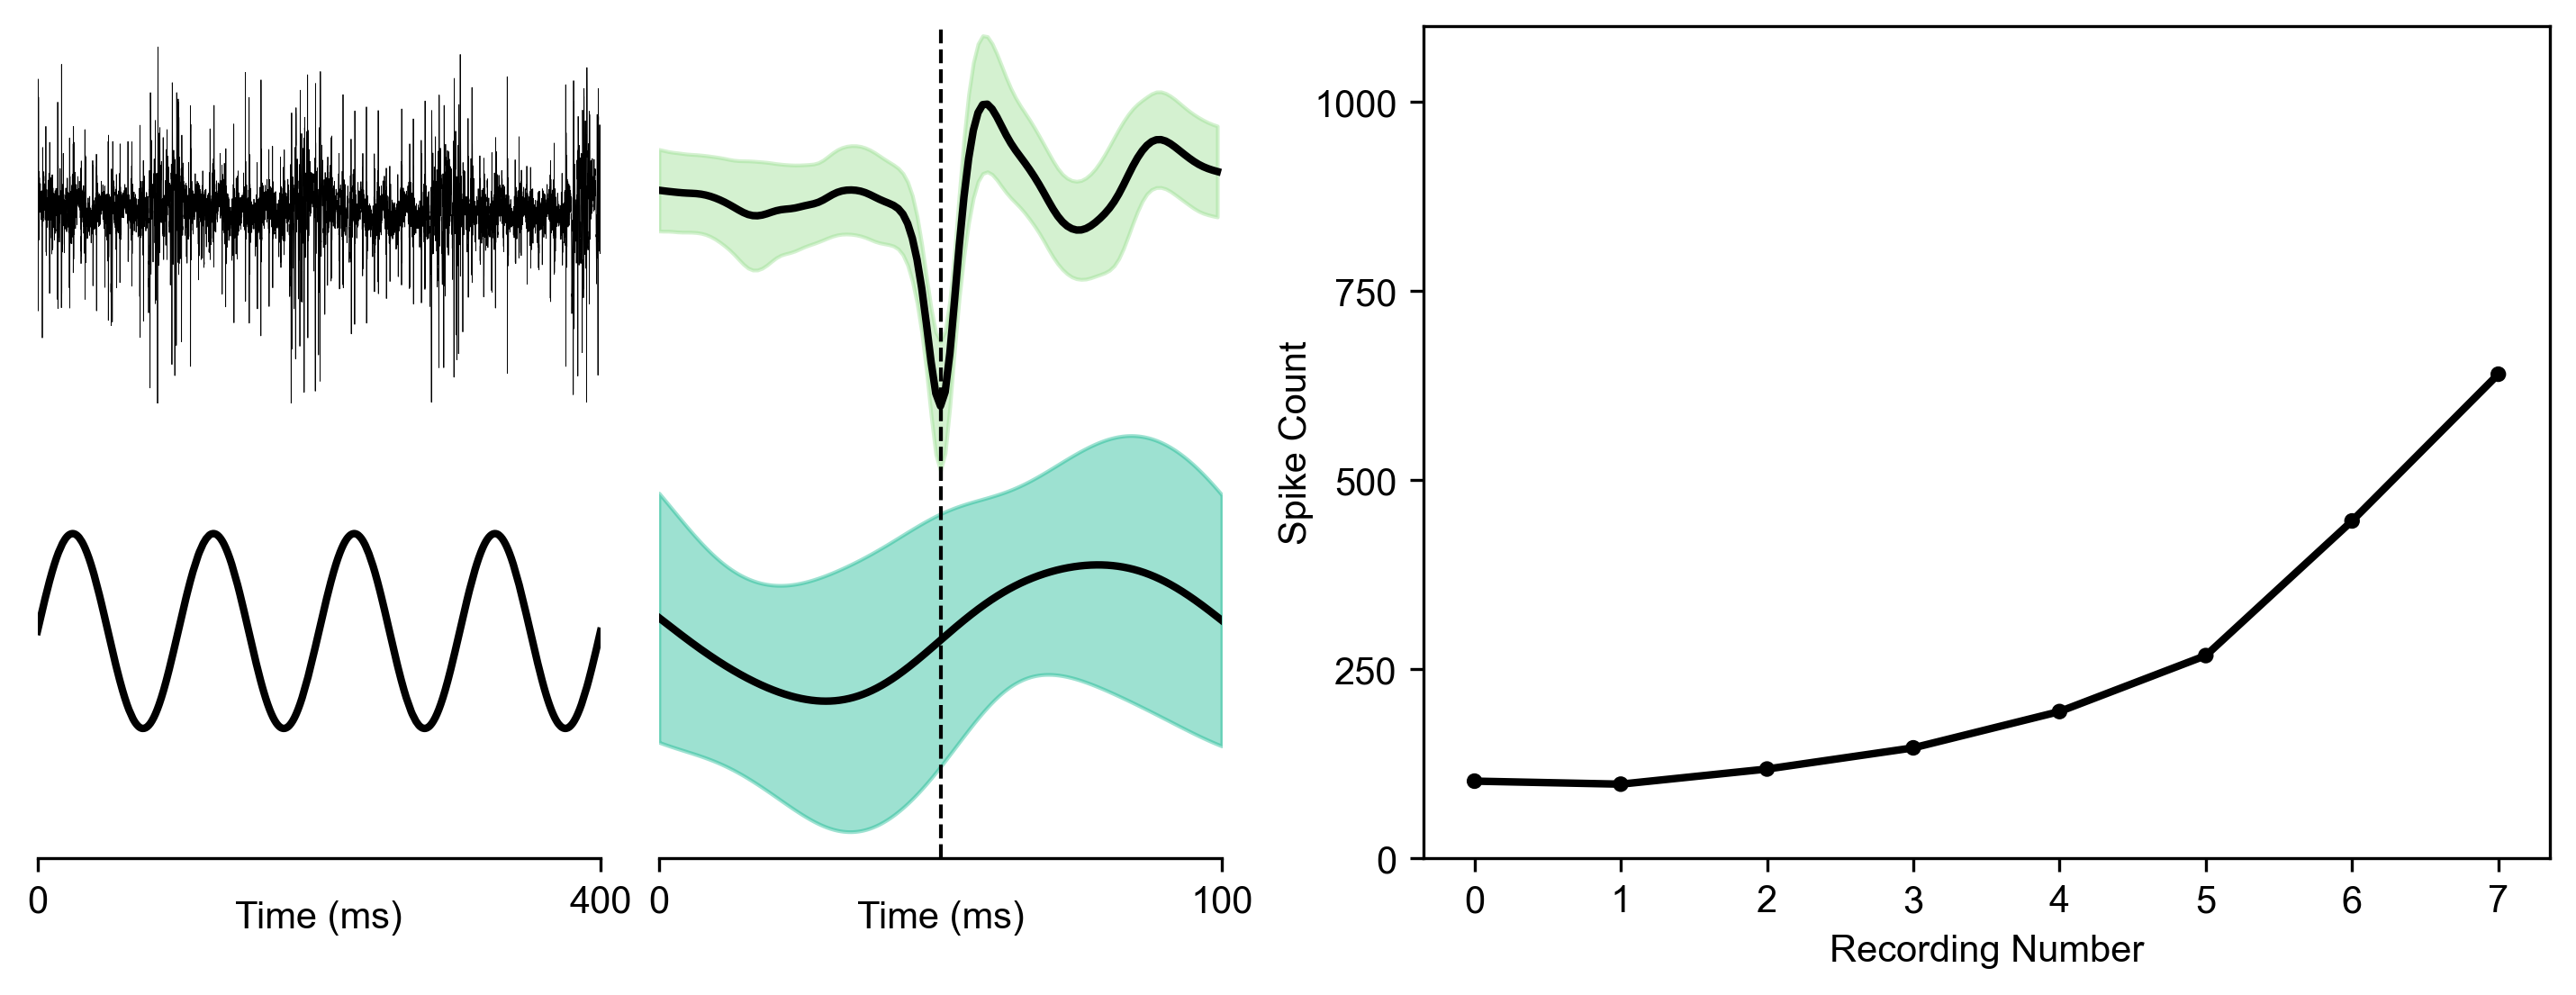

In [302]:
plt.rcParams['font.family'] = 'Arial'

fig = plt.figure(figsize=(12, 4), dpi=300)
gs2 = gridspec.GridSpec(1, 4, hspace=0.0, wspace=0.1, width_ratios=[2, 2, 0.3, 4])
pannel1_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs2[0, 0], height_ratios=[1, 1], hspace=-0.17)
pannel2_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs2[0, 1], height_ratios=[1, 1], hspace=-0.17)

#Figure 2A
ax1top = fig.add_subplot(pannel1_gs[0])
plt.plot(spine3trials['block_14'][0,932000:948000]*-1000,
        color = 'black',
        linewidth = 0.2
        )
ax1top.set_xbound([0, 16000])


ax1bot = fig.add_subplot(pannel1_gs[1])
plt.plot(spine3trials['block_14'][2,932000:948000]*1000,
        color = 'black',
        linewidth = 2
        )
ax1bot.set_ybound([-350, 350])
ax1bot.set_xbound([0, 16000])
ax1bot.set_xticks([0,16000],[0, 400])
plt.xlabel('Time (ms)', labelpad=-5)

ax2bot = fig.add_subplot(pannel2_gs[1])
plt.fill_between(np.arange(len(sta_avg)), 
                 (sta_avg - sta_std) * 1000,
                 (sta_avg + sta_std) * 1000,
                 color=colors['green2'], alpha=0.4)
plt.plot(sta_avg * 1000, c='black', linewidth=2)
plt.axvline(x=2000, color='black', linestyle='--', linewidth=1)

ax2bot.set_xbound([0,4000])
ax2bot.set_xticks([0, 4000],[0, 100])
plt.xlabel('Time (ms)', labelpad=-5)

ax2bot.set_ybound([-170, 170])
ax2bot.set_yticks([0, 50])

ax2top = fig.add_subplot(pannel2_gs[0])
plt.fill_between(np.arange(len(wholedata_cluster_avg)), 
                 (wholedata_cluster_avg - all_wfs_std) * -1000,
                 (wholedata_cluster_avg + all_wfs_std) * -1000,
                 color=colors['green1'], alpha=0.4)
plt.plot(wholedata_cluster_avg *-1000, c='black', linewidth=2)
plt.axvline(x=60, color='black', linestyle='--', linewidth=1)

ax2top.set_xbound([0,120])
ax2top.set_xticks([0, 20], [0, 500])
ax2top.tick_params(axis='x', direction='in', length=30)

ax2top.set_ybound([-16, 9.5])
ax2top.set_yticks([0, 5])

ax3 = fig.add_subplot(gs2[0, 2])
ax3.axis('off')

ax4 = fig.add_subplot(gs2[0, 3])
spike_count = FR_reorder[:30]*16  # Exclude rows 30-33 (spine 1 frequency data)
x = np.arange(len(spike_count))  # Generate x-values for the remaining data

# Define color mapping based on row ranges (excluding rows 30-33)
dot_colors = []

for i in range(len(spike_count)):  # Loop only through the remaining data
    if 0 <= i <= 9:         # Spontaneous data
        dot_colors.append('black')
    elif 10 <= i <= 14:      # Spine 1 amplitude data
        dot_colors.append(colors['red'])
    elif 15 <= i <= 19:      # Spine 2 amplitude data
        dot_colors.append(colors['gold'])
    elif 20 <= i <= 24:      # Spine 3 amplitude data
        dot_colors.append(colors['aqua'])
    elif 25 <= i <= 29:      # Spine 4 amplitude data
        dot_colors.append(colors['blue'])

# Plot the color-coded dots
plt.scatter(x, spike_count, color=dot_colors, s=10)

# Connect adjacent dots of the same color with a line
for i in range(len(spike_count) - 1):
    if dot_colors[i] == dot_colors[i + 1]:  # Check if the colors are the same
        plt.plot(x[i:i + 2], spike_count[i:i + 2], color=dot_colors[i], linewidth=2)

ax4.set_yticks([0, 250, 500, 750, 1000])
ax4.set_ybound(0, 1100)

plt.xlabel('Recording Number')
plt.ylabel('Spike Count', labelpad=0)

#clean
ax1top.axis('off')
ax1bot.spines['top'].set_visible(False)
ax1bot.spines['left'].set_visible(False)
ax1bot.spines['right'].set_visible(False)
ax1bot.tick_params(axis='y', which='both', left=False, right=False)
ax1bot.set_yticklabels([])

ax2top.axis('off')
ax2bot.spines['top'].set_visible(False)
ax2bot.spines['left'].set_visible(False)
ax2bot.spines['right'].set_visible(False)
ax2bot.tick_params(axis='y', which='both', left=False, right=False)
ax2bot.set_yticklabels([])

plt.tight_layout()
plt.show()


## Figure 2D

/var/folders/8m/rn7r2gs515b4cjxyfyfv6wz00000gn/T/ipykernel_19640/1467685606.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


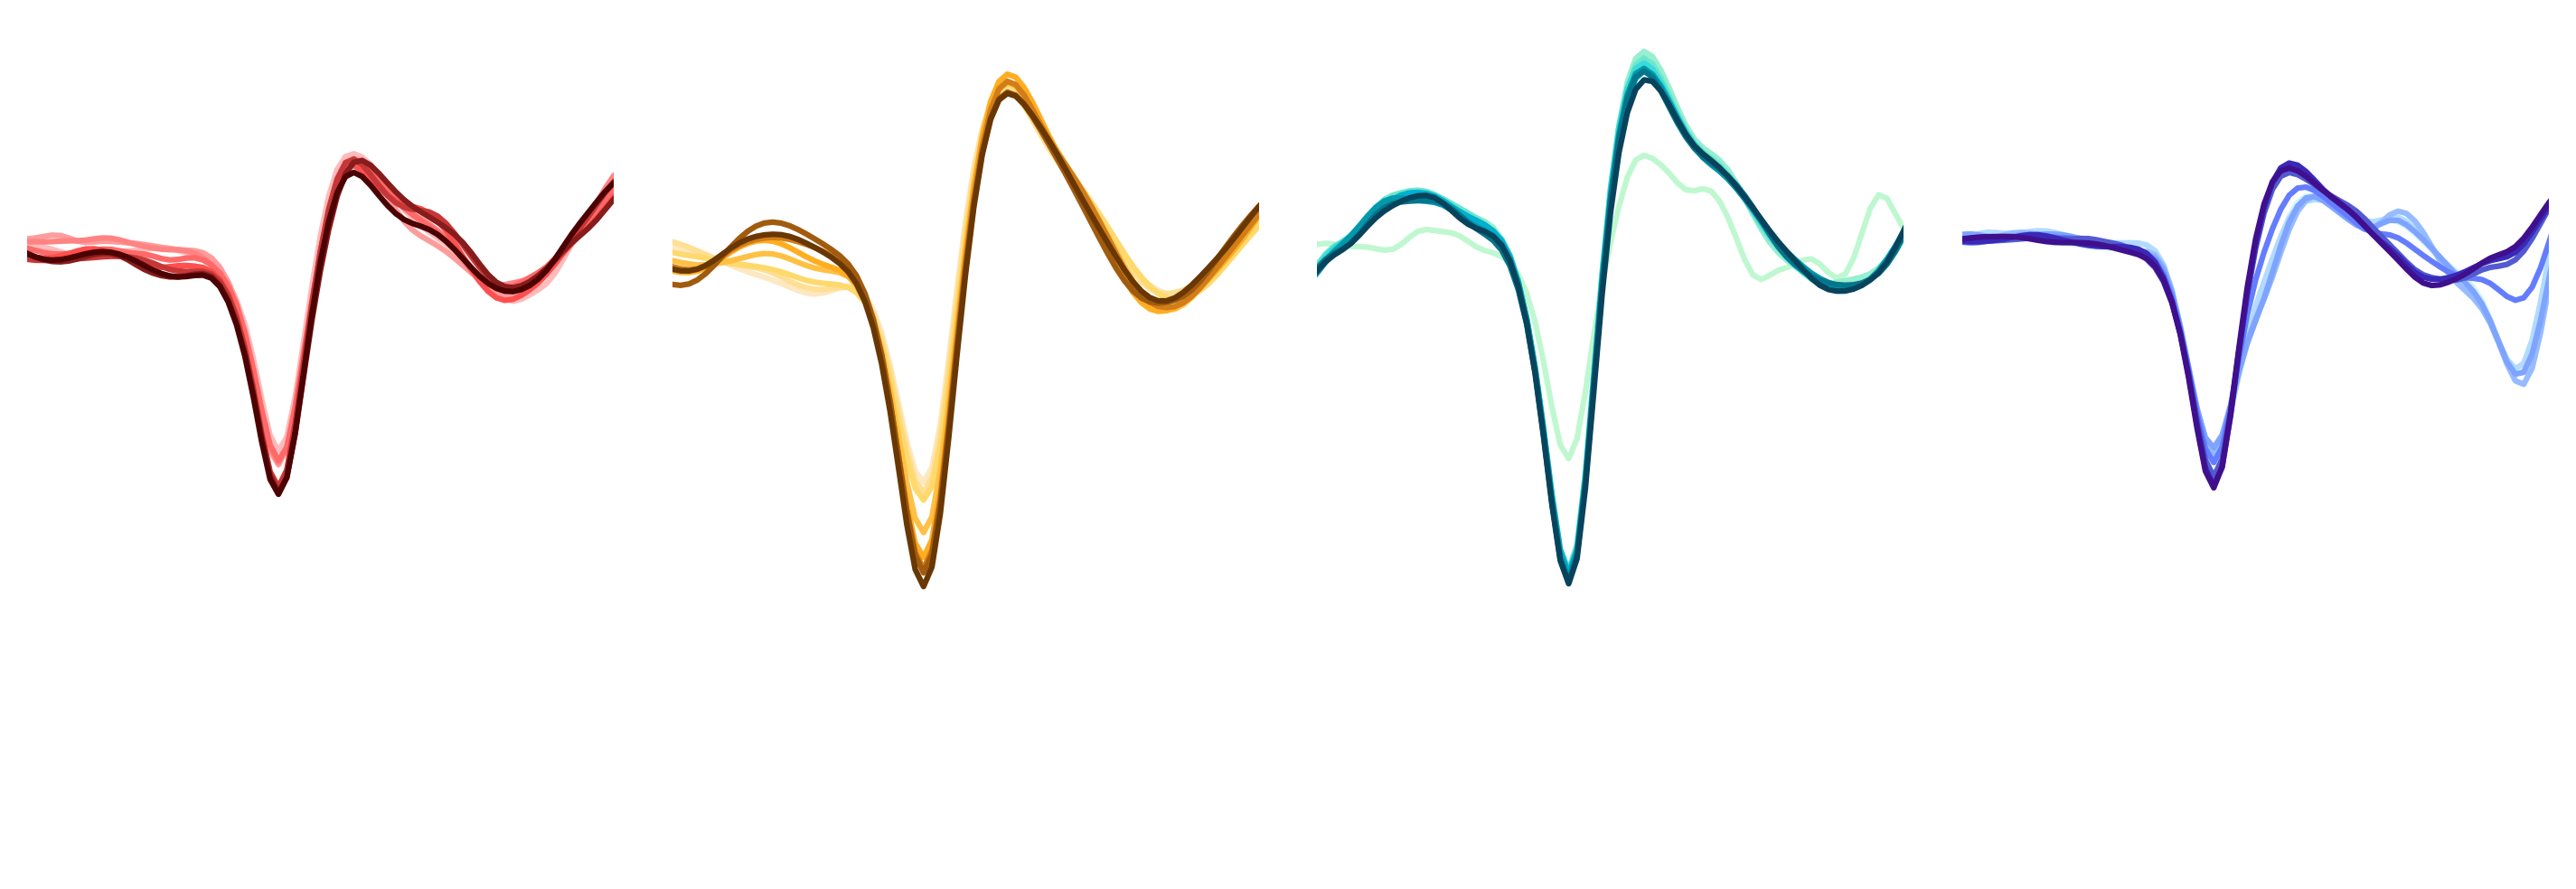

In [252]:
fig = plt.figure(figsize=(12, 4), dpi=300)
gs21 = gridspec.GridSpec(1, 4, hspace=0.0, wspace=0.1)

ybound = -26

#Spine 1
ax1 = fig.add_subplot(gs21[0, 0])
plt.plot(S1A1_avg_wf, color = colors['red1'])
plt.plot(S1A2_avg_wf, color = colors['red2'])
plt.plot(S1A3_avg_wf, color = colors['red3'])
plt.plot(S1A4_avg_wf, color = colors['red4'])
plt.plot(S1A5_avg_wf, color = colors['red5'])
plt.plot(S1A6_avg_wf, color = colors['red6'])
plt.plot(S1A7_avg_wf, color = colors['red7'])
plt.plot(S1A8_avg_wf, color = colors['red8'])

ax1.set_xbound([30,100])
ax1.set_xticks([30, 40], [0, 10])

ax1.set_ybound([ybound,9])
ax1.set_yticks([0, 2.5])

#Spine 2
ax2 = fig.add_subplot(gs21[0, 1])
plt.plot(S2A1_avg_wf, color = colors['gold1'])
plt.plot(S2A2_avg_wf, color = colors['gold2'])
plt.plot(S2A3_avg_wf, color = colors['gold3'])
plt.plot(S2A4_avg_wf, color = colors['gold4'])
plt.plot(S2A5_avg_wf, color = colors['gold5'])
plt.plot(S2A6_avg_wf, color = colors['gold6'])
plt.plot(S2A7_avg_wf, color = colors['gold7'])
plt.plot(S2A8_avg_wf, color = colors['gold8'])

ax2.set_xbound([30,100])
ax2.set_xticks([30, 40], [0, 10])

ax2.set_ybound([ybound,9])
ax2.set_yticks([0, 2.5])

#Spine 3
ax3 = fig.add_subplot(gs21[0, 2])
plt.plot(S3A1_avg_wf, color = colors['aqua1'])
plt.plot(S3A2_avg_wf, color = colors['aqua2'])
plt.plot(S3A3_avg_wf, color = colors['aqua3'])
plt.plot(S3A4_avg_wf, color = colors['aqua4'])
plt.plot(S3A5_avg_wf, color = colors['aqua5'])
plt.plot(S3A6_avg_wf, color = colors['aqua6'])
plt.plot(S3A7_avg_wf, color = colors['aqua7'])
plt.plot(S3A8_avg_wf, color = colors['aqua8'])

ax3.set_xbound([30,100])
ax3.set_xticks([30, 40], [0, 10])

ax3.set_ybound([ybound,9])
ax3.set_yticks([0, 2.5])

#Spine 4
ax4 = fig.add_subplot(gs21[0, 3])
plt.plot(S4A1_avg_wf, color = colors['blue1'])
plt.plot(S4A2_avg_wf, color = colors['blue2'])
plt.plot(S4A3_avg_wf, color = colors['blue3'])
plt.plot(S4A4_avg_wf, color = colors['blue4'])
plt.plot(S4A5_avg_wf, color = colors['blue5'])
plt.plot(S4A6_avg_wf, color = colors['blue6'])
plt.plot(S4A7_avg_wf, color = colors['blue7'])
plt.plot(S4A8_avg_wf, color = colors['blue8'])

ax4.set_xbound([30,100])
ax4.set_xticks([30, 40], [0, 250])

ax4.set_ybound([ybound,9])
ax4.set_yticks([0, 2.5])

#clean
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.tight_layout()
plt.show()

## Figure 2E-G

/var/folders/8m/rn7r2gs515b4cjxyfyfv6wz00000gn/T/ipykernel_19640/256763376.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


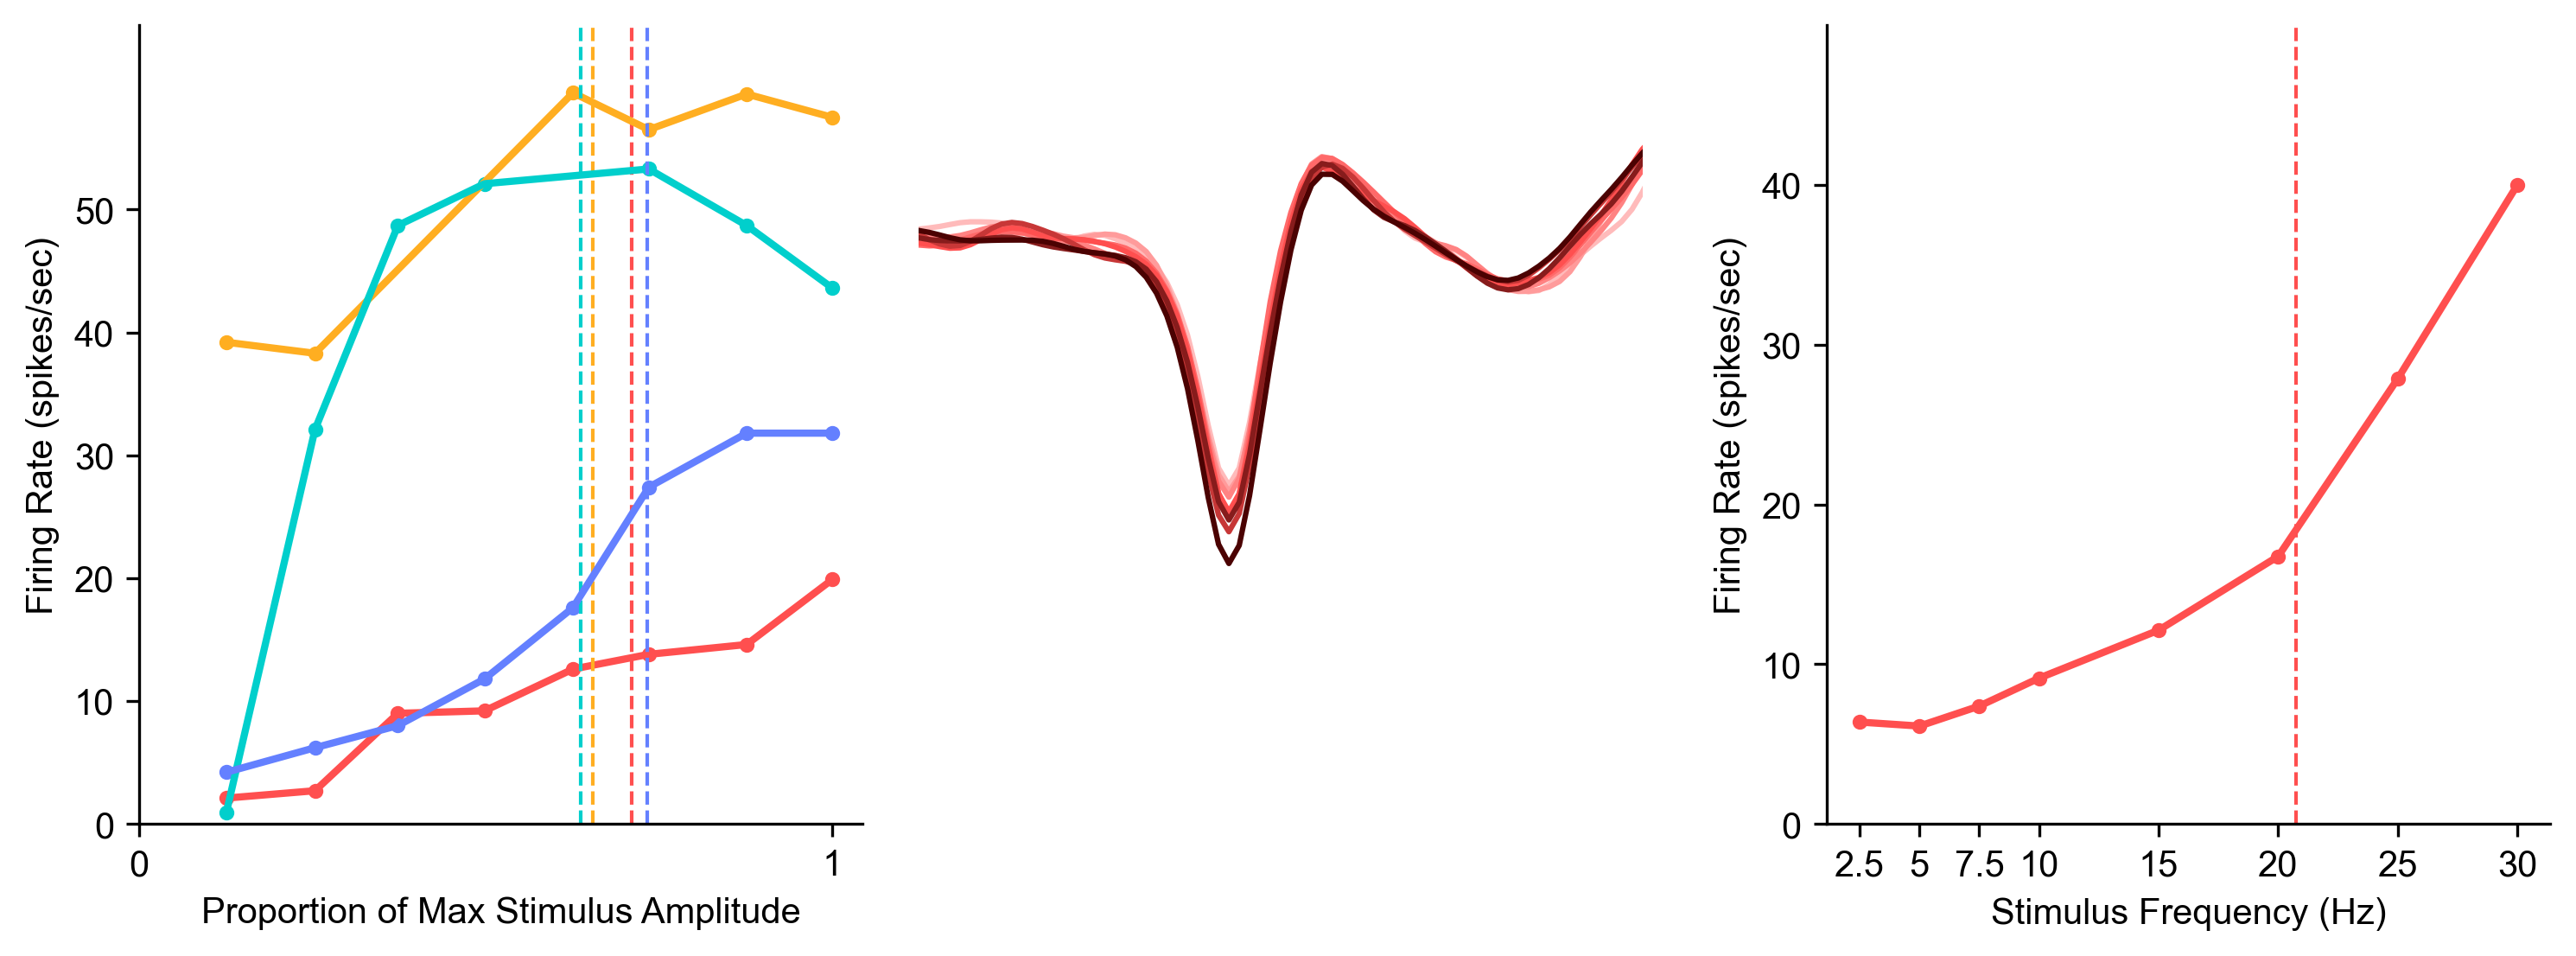

In [258]:
fig = plt.figure(figsize=(12, 4), dpi=300)
gs22 = gridspec.GridSpec(1, 4, hspace=0.0, wspace=0.1, width_ratios=[1, 1, 0.1, 1])

#figure 2E
ax1 = fig.add_subplot(gs22[0, 0])
amplitude_values = [29.5, 59.6, 87.7, 117.1, 147.1, 172.8, 206.0, 235.1]
max_amplitude = 235.1

weighted_averages = {}

# Calculate proportions of max amplitude
proportions = [amp / max_amplitude for amp in amplitude_values]

# Prepare data for scatter plot
firing_rates = []  # List to hold firing rates
spine_numbers = []  # List to hold spine numbers
amplitude_indices = []  # List to hold amplitude indices

# Loop through all combinations of S (1-4) and A (1-8)
for S in range(1, 5):
    for A in range(1, 9):
        # Construct the firing rate variable name
        firing_rate_variable_name = f'S{S}A{A}_FR'
        
        # Check if firing rate exists in the dictionary
        if firing_rate_variable_name in firing_rate_dict:
            firing_rates.append(firing_rate_dict[firing_rate_variable_name])
            spine_numbers.append(S)  # Spine number is the number after S
            amplitude_indices.append(A - 1)  # Store the amplitude index (0-based)

# Define custom colors for each spine number using the existing colors dictionary
FRcolors = {1: colors['red'], 2: colors['gold'], 3: colors['aqua'], 4: colors['blue']}

# Loop through the unique spine numbers and plot each with the corresponding color
for spine in FRcolors.keys():
    # Get the indices of the points corresponding to the current spine number
    indices = [i for i, s in enumerate(spine_numbers) if s == spine]
    
    # Filter out points based on a condition (e.g., firing rate < 1)
    filtered_indices = [i for i in indices if firing_rates[i] <= 60]  # Example condition

    # Check if there are any filtered points to plot
    if filtered_indices:
        plt.scatter(
            [proportions[amplitude_indices[i]] for i in filtered_indices],  # Use amplitude index
            [firing_rates[i] for i in filtered_indices],
            color=FRcolors[spine],
            label=f'Spine {spine}',
            s=10,
            alpha=1
        )

        sorted_filtered_indices = sorted(filtered_indices, key=lambda i: proportions[amplitude_indices[i]])

        plt.plot(
            [proportions[amplitude_indices[i]] for i in sorted_filtered_indices],
            [firing_rates[i] for i in sorted_filtered_indices],
            color=FRcolors[spine],
            linewidth=2,
            alpha=1)

        # Calculate weighted average for the x-values (proportions) with the filtered points
        weights = [firing_rates[i] for i in filtered_indices]  # Use filtered firing rates as weights
        weighted_x_sum = sum(proportions[amplitude_indices[i]] * firing_rates[i] for i in filtered_indices)
        total_weight = sum(weights)
        weighted_average_x = weighted_x_sum / total_weight if total_weight != 0 else 0  # Avoid division by zero

        # Draw a vertical line at the weighted average x-value
        plt.axvline(x=weighted_average_x, color=FRcolors[spine], linestyle='--', linewidth=1, label=f'Weighted Avg Spine {spine}')

# Label axes and title
plt.xlabel('Proportion of Max Stimulus Amplitude')
plt.ylabel('Firing Rate (spikes/sec)')

#ax1.axis('off')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 10, 20, 30, 40, 50])
ax1.set_ybound(0,65)


#figure 2F
ax2 = fig.add_subplot(gs22[0, 1])

plt.plot(S1F1_avg_wf, color = colors['red1'])
plt.plot(S1F2_avg_wf, color = colors['red2'])
plt.plot(S1F3_avg_wf, color = colors['red3'])
plt.plot(S1F4_avg_wf, color = colors['red4'])
plt.plot(S1F5_avg_wf, color = colors['red5'])
plt.plot(S1F6_avg_wf, color = colors['red6'])
plt.plot(S1F7_avg_wf, color = colors['red7'])
plt.plot(S1F8_avg_wf, color = colors['red8'])

ax2.set_xbound([30,100])
ax2.set_xticks([30, 40], [0, 250])

ax2.set_ybound([-20,7])
ax2.set_yticks([0, 2.5])

ax3 = fig.add_subplot(gs22[0,2])
ax3.axis('off')

#Figure 2G
ax4 = fig.add_subplot(gs22[0, 3])
# Frequency values in Hz
frequency_values = [2.5, 5, 7.5, 10, 15, 20, 25, 30]

# Prepare data for scatter plot
firing_rates = []  # List to hold firing rates
frequency_indices = []  # List to hold frequency indices

# Loop through the frequencies for S1 (only)
for F in range(1, 9):  # F1 to F8
    # Construct the firing rate variable name
    firing_rate_variable_name = f'S1F{F}_FR'
    
    # Check if firing rate exists in the dictionary
    if firing_rate_variable_name in firing_rate_dict:
        firing_rates.append(firing_rate_dict[firing_rate_variable_name])
        frequency_indices.append(F - 1)  # Store the frequency index (0-based)

# Single color for spine 1
color = colors['red']  # Change to your desired color

# Plotting the data for spine 1
plt.scatter(
    frequency_values,  # Use frequency values directly
    firing_rates,
    color=color,
    label='Spine 1',
    s=10,
    alpha=1
)

# Connect points with a line
plt.plot(
    frequency_values,
    firing_rates,
    color=color,
    linewidth=2,
    alpha=1
)

# Calculate weighted average
weights = firing_rates  # Using firing rates as weights
weighted_x_sum = sum(frequency_values[i] * firing_rates[i] for i in range(len(firing_rates)))
total_weight = sum(weights)
weighted_average_x = weighted_x_sum / total_weight if total_weight != 0 else 0  # Avoid division by zero

# Draw a vertical line at the weighted average x-value
plt.axvline(x=weighted_average_x, color=colors['red'], linestyle='--', linewidth=1, label='Weighted Average')

# Label axes and title
plt.xlabel('Stimulus Frequency (Hz)')
plt.ylabel('Firing Rate (spikes/sec)')
ax4.set_yticks([0, 10, 20, 30, 40])

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(True)
ax4.spines['bottom'].set_visible(True)

ax4.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax4.set_xticks(frequency_values)
ax4.set_ybound(0, 50) 

#clean
ax2.axis('off')

plt.tight_layout()
plt.show()

# Processing For Figure 3

In [219]:
#delay times
half_width = 1500

S1_peaktime = 6.00
S2_peaktime = 8.87
S3_peaktime = 11.25
S4_peaktime = 13.00

S1_delay = S1_peaktime - (half_width)
S2_delay = S2_peaktime - (half_width)
S3_delay = S3_peaktime - (half_width)
S4_delay = S4_peaktime - (half_width)

In [122]:
#Get avg waveform for spine 1
spine1_wf_master = []

for R in range(25, 30):
    wfs = wfs_byRecording[R]
    spine1_wf_master.append(wfs)

combined_S1wfs = np.vstack(spine1_wf_master)
S1_avg_wf = np.mean(combined_S1wfs, axis=0) * -1000
    

In [123]:
#Get avg waveform for spine 2
spine2_wf_master = []

for R in range(20, 25):
    wfs = wfs_byRecording[R]
    spine2_wf_master.append(wfs)

combined_S2wfs = np.vstack(spine2_wf_master)
S2_avg_wf = np.mean(combined_S2wfs, axis=0) * -1000

In [124]:
#Get avg waveform for spine 3
spine3_wf_master = []

for R in range(10, 15):
    wfs = wfs_byRecording[R]
    spine3_wf_master.append(wfs)

combined_S3wfs = np.vstack(spine3_wf_master)
S3_avg_wf = np.mean(combined_S3wfs, axis=0) * -1000

In [125]:
#Get avg waveform for spine 4
spine4_wf_master = []

for R in range(15, 20):
    wfs = wfs_byRecording[R]
    spine4_wf_master.append(wfs)

combined_S4wfs = np.vstack(spine4_wf_master)
S4_avg_wf = np.mean(combined_S4wfs, axis=0) * -1000

In [367]:
delay_times = []
valley_times = [1202970, 1206970, 1210970, 1214970, 1218970, 1222970, 1226970, 1230970, 1234970, 1238970, 1242970, 1246970, 1250970, 1254970, 1258970, 1262970, 1266970, 1270970, 1274970, 1278970, 12982970]
d_times = [time + 10000 for time in valley_times]
peak_times = [time + 40000 for time in valley_times]
grouped_delays = {0: [], 1: [], 2: [], 3: []}


for i in range(10, 30):
    spike_times_amp8 = spike_times_by_amp['Amp8_spike_times'][i]
    
    # Calculate delay times for each spike time
    delays = []
    for spike_time in spike_times_amp8:
        # Find the largest onset time that is less than the spike time
        valid_onsets = [onset for onset in peak_times if onset < spike_time]
        if valid_onsets:
            nearest_onset = max(valid_onsets)
            delay = (spike_time - 60) -  nearest_onset
            delays.append(delay)

    # Assign the delays to the correct group (10-14 -> group 0, 15-19 -> group 1, etc.)
    if delays:
        group_idx = (i - 10) // 5  # This will group indices 10-14 as 0, 15-19 as 1, etc.
        grouped_delays[group_idx].extend(delays)

std_delays = []

for group in grouped_delays.values():
    if group:  # Only calculate if the group has delays
        avg_delay = np.mean(group)
        std_delay = np.std(group)
        delay_times.append(avg_delay)
        std_delays.append(std_delay)


In [368]:
S3_delay = delay_times[0] / 40
S4_delay = delay_times[1] / 40
S2_delay = delay_times[2] / 40
S1_delay = delay_times[3] / 40

S3_delay_std = std_delays[0] / 40
S4_delay_std = std_delays[1] / 40
S2_delay_std = std_delays[2] / 40
S1_delay_std = std_delays[3] / 40

In [369]:
print(S3_delay)
print(S2_delay)
print(S1_delay)
print(S4_delay)

19.452864583333334
27.869777397260275
10.742897727272727
21.479432624113475


# Figure 3

/var/folders/8m/rn7r2gs515b4cjxyfyfv6wz00000gn/T/ipykernel_19640/2294723781.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


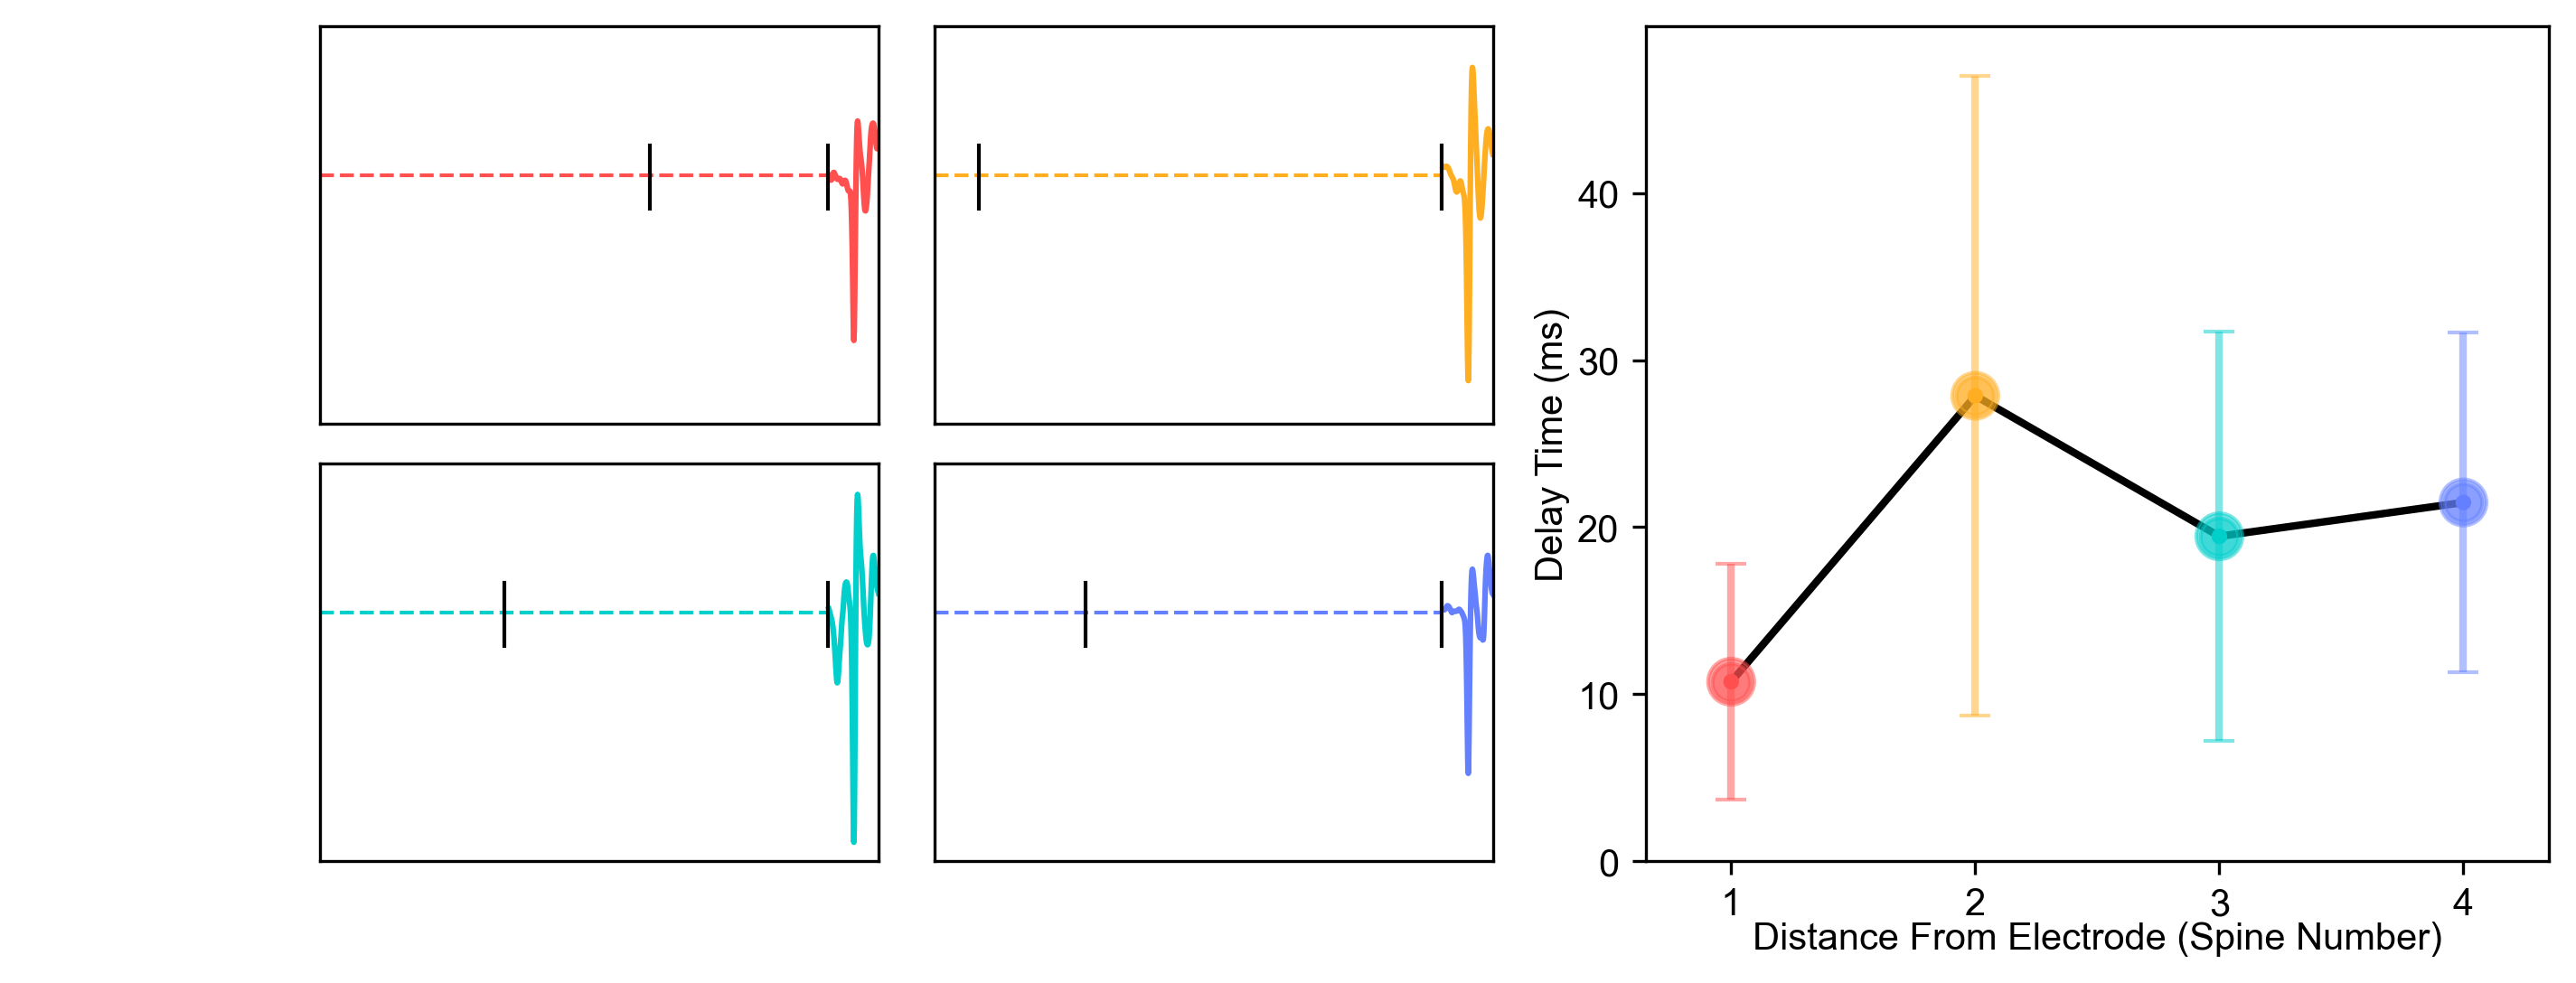

In [390]:
fig = plt.figure(figsize=(12, 4), dpi=300)
gs3 = gridspec.GridSpec(1, 4, hspace=0.0, wspace=0.1, width_ratios=[0.2, 1, 0.03, 0.77])
delaygs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs3[0, 1], hspace=0.1, wspace=0.1)

ax0 = fig.add_subplot(gs3[0, 0])
ax0.axis('off')

ax1LUQ = fig.add_subplot(delaygs[0, 0])
plt.plot(S1_avg_wf, color = colors['red'])
plt.axhline(y=0, xmax=0.91, color=colors['red'], linewidth=1, linestyle='--')


plt.axvline(x=(0-delay_times[3]), ymin=0.54, ymax=0.7, color='black', linewidth=1)
plt.axvline(x=-3, ymin=0.54, ymax=0.7, color='black', linewidth=1)

ax1LUQ.set_xbound([-1220,120])
ax1LUQ.set_xticks([-1220, -1020], [0, 200])

ax1LUQ.set_ybound([-15,9])
ax1LUQ.set_yticks([0, 5])


ax1RUQ = fig.add_subplot(delaygs[0, 1])
plt.plot(S2_avg_wf, color = colors['gold'])
plt.axhline(y=0, xmax=0.91, color=colors['gold'], linewidth=1, linestyle='--')

plt.axvline(x=(0-delay_times[2]),  ymin=0.54, ymax=0.7, color='black', linewidth=1)
plt.axvline(x=-3, ymin=0.54, ymax=0.7, color='black', linewidth=1)

ax1RUQ.set_xbound([-1220,120])
ax1RUQ.set_xticks([-520, -440], [0, 80])

ax1RUQ.set_ybound([-15,9])
ax1RUQ.set_yticks([0, 5])


ax1LLQ = fig.add_subplot(delaygs[1, 0])
plt.plot(S3_avg_wf, color = colors['aqua'])
plt.axhline(y=0, xmax=0.91, color=colors['aqua'], linewidth=1, linestyle='--')

plt.axvline(x=(0-delay_times[0]), ymin=0.54, ymax=0.7, color='black', linewidth=1)
plt.axvline(x=-3, ymin=0.54, ymax=0.7, color='black', linewidth=1)

ax1LLQ.set_xbound([-1220,120])
ax1LLQ.set_xticks([-520, -440], [0, 80])

ax1LLQ.set_ybound([-15,9])
ax1LLQ.set_yticks([0, 5])


ax1RLQ = fig.add_subplot(delaygs[1, 1])
plt.plot(S4_avg_wf, color = colors['blue'])
plt.axhline(y=0, xmax=0.91, color=colors['blue'], linewidth=1, linestyle='--')

plt.axvline(x=(0-delay_times[1]), ymin=0.54, ymax=0.7, color='black', linewidth=1)
plt.axvline(x=-3, ymin=0.54, ymax=0.7, color='black', linewidth=1)

ax1RLQ.set_xbound([-1220,120])
ax1RLQ.set_xticks([-520, -440], [0, 80])

ax1RLQ.set_ybound([-15,9])
ax1RLQ.set_yticks([0, 5])


ax3 = fig.add_subplot(gs3[0, 2])
ax3.axis('off')

ax3 = fig.add_subplot(gs3[0, 3])
x = [1, 2, 3, 4]
y = [S1_delay, S2_delay, S3_delay, S4_delay]
yerr = [S1_delay_std, S2_delay_std, S3_delay_std, S4_delay_std]
color_points = colors['red'], colors['gold'], colors['aqua'], colors['blue']

for i in range(len(x)):
    ax3.errorbar(
        x[i], y[i], yerr=yerr[i], fmt='o', color=color_points[i], ecolor=color_points[i], 
        elinewidth=2, capsize=4, markersize=10, alpha=0.5, zorder=1
    )

plt.plot(x, y, color='black', linewidth=2, zorder=0)
plt.scatter(x, y, c=color_points, s=150, alpha=0.5, zorder=1)
plt.scatter(x, y, c=color_points, edgecolors=None, s=10, alpha=1, zorder=2)

plt.xlabel('Distance From Electrode (Spine Number)', labelpad=-0.3)
plt.xticks([1, 2, 3, 4])  # Only show ticks for 1, 2, 3, and 4

# Set y-axis title and ticks
plt.ylabel('Delay Time (ms)', labelpad=2)
ax3.set_ybound([0,50])
ax3.set_yticks([0,10, 20, 30, 40])
ax3.set_xbound([0.65, 4.35])

#clean
ax1LUQ.set_xticklabels([])
ax1RUQ.set_xticklabels([])
ax1LLQ.set_xticklabels([])
ax1RLQ.set_xticklabels([])

ax1LUQ.set_yticklabels([])
ax1RUQ.set_yticklabels([])
ax1LLQ.set_yticklabels([])
ax1RLQ.set_yticklabels([])

ax1LUQ.tick_params(axis='both', which='both', length=0)
ax1RUQ.tick_params(axis='both', which='both', length=0)
ax1LLQ.tick_params(axis='both', which='both', length=0)
ax1RLQ.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()